# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [18]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib
import matplotlib.pyplot as plt


# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.996
num_episodes = 2500
batch_size = 64
replay_buffer_size = 50000

evaluation_episodes = 5
import torch, sys
print("Python executable:", sys.executable)
print("Torch version:", torch.__version__)
print("Torch file:", torch.__file__)


print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Python executable: C:\Users\wts28\CSE\labwork\RL_CSE337_TonyWu\.venv\Scripts\python.exe
Torch version: 2.5.1+cu121
Torch file: C:\Users\wts28\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py
2.5.1+cu121
True
NVIDIA GeForce RTX 4080
cuda


In [19]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [20]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [21]:
def epsilon_greedy(state, epsilon):
  ############ TODO ###########
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = q_net(state_tensor)
        action = torch.argmax(q_values, dim=1).item()
    return action


In [22]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(np.array(actions)).to(device)
    rewards = torch.FloatTensor(np.array(rewards)).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).to(device)
    dones = torch.FloatTensor(np.array(dones)).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [23]:
## MAIN Loop ###
eval_every = 50
print_every = 100
rewards_dqn = []
eval_eps = []
eval_rewards = []
eval_epsilon = 0

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ############ TODO ###########
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        state = next_state
        total_reward += reward


    rewards_dqn.append(total_reward)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    if (episode + 1) % print_every == 0:
        avg_reward = np.mean(rewards_dqn[-print_every:])
        print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

    if (episode + 1) % eval_every == 0:
            total_eval_reward = 0

            for _ in range(evaluation_episodes):
                s, _ = env.reset()
                ep_reward, done = 0, False
                while not done:
                    a = epsilon_greedy(s, 0.0)
                    ns, r, term, trunc, _ = env.step(a)
                    done = term or trunc
                    s = ns
                    ep_reward += r
                total_eval_reward += ep_reward

            avg_eval_reward = total_eval_reward / evaluation_episodes
            eval_eps.append(episode + 1)
            eval_rewards.append(avg_eval_reward)

            print(f"Evaluation after {episode + 1} episodes: Average Reward: {avg_eval_reward:.2f}")



print("Training completed.")


Evaluation after 50 episodes: Average Reward: -200.00
Episode 100, Avg Reward: -200.00, Epsilon: 0.670
Evaluation after 100 episodes: Average Reward: -200.00
Evaluation after 150 episodes: Average Reward: -200.00
Episode 200, Avg Reward: -200.00, Epsilon: 0.449
Evaluation after 200 episodes: Average Reward: -185.20
Evaluation after 250 episodes: Average Reward: -200.00
Episode 300, Avg Reward: -197.46, Epsilon: 0.300
Evaluation after 300 episodes: Average Reward: -140.20
Evaluation after 350 episodes: Average Reward: -115.00
Episode 400, Avg Reward: -170.73, Epsilon: 0.201
Evaluation after 400 episodes: Average Reward: -156.20
Evaluation after 450 episodes: Average Reward: -129.20
Episode 500, Avg Reward: -150.43, Epsilon: 0.135
Evaluation after 500 episodes: Average Reward: -126.40
Evaluation after 550 episodes: Average Reward: -184.20
Episode 600, Avg Reward: -148.32, Epsilon: 0.090
Evaluation after 600 episodes: Average Reward: -124.20
Evaluation after 650 episodes: Average Reward: 

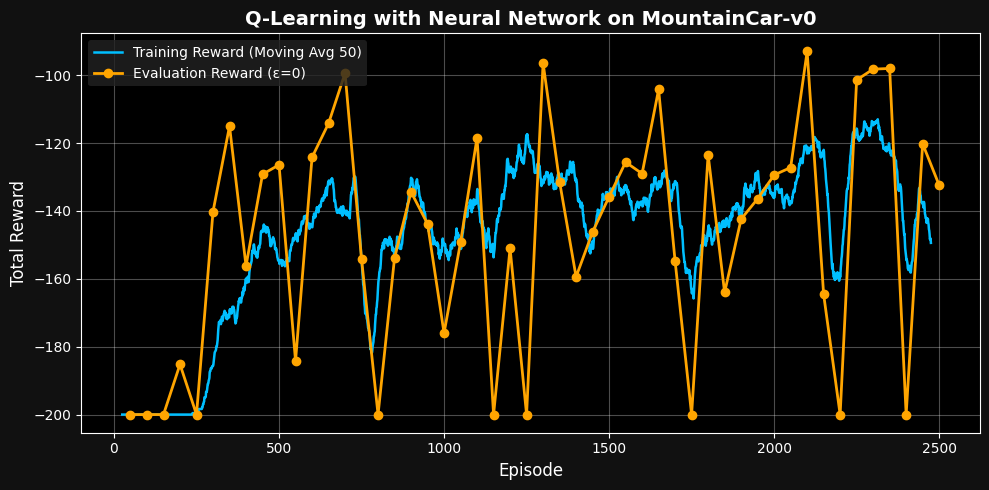

In [24]:

window = 50
if len(rewards_dqn) > window:
    smooth_rewards = np.convolve(rewards_dqn, np.ones(window)/window, mode='valid')
    smooth_episodes = np.arange(window//2, window//2 + len(smooth_rewards))
else:
    smooth_rewards = rewards_dqn
    smooth_episodes = np.arange(len(rewards_dqn))


plt.figure(figsize=(10,5), facecolor="#111111")
plt.style.use("dark_background")


plt.plot(smooth_episodes, smooth_rewards, color="deepskyblue", linewidth=1.8,
         label=f"Training Reward (Moving Avg {window})")


plt.plot(eval_eps, eval_rewards, "o-", color="orange", linewidth=2, markersize=6,
         label="Evaluation Reward (ε=0)")


plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward", fontsize=12)
plt.title("Q-Learning with Neural Network on MountainCar-v0", fontsize=14, weight='bold')

plt.grid(alpha=0.3)
plt.legend(facecolor="#222222", edgecolor="none", fontsize=10)
plt.tight_layout()
plt.show()

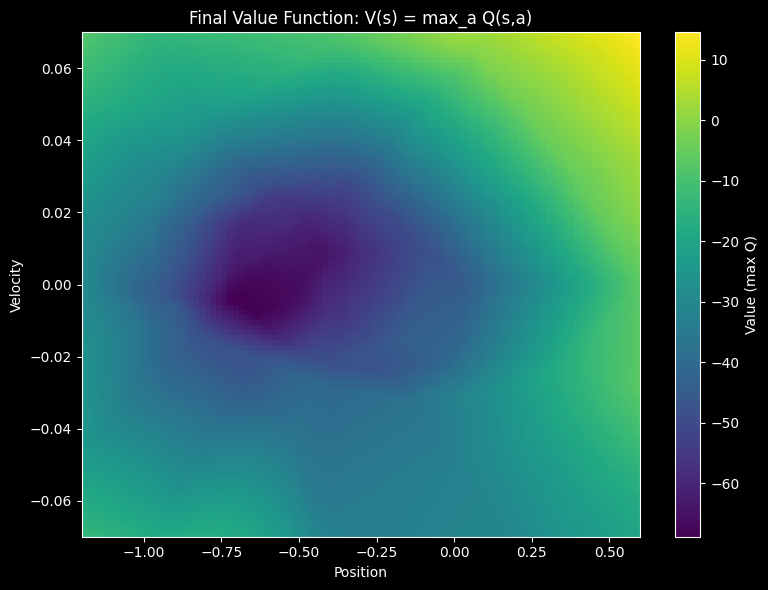

In [25]:
pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 100)
vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 100)


value_grid = np.zeros((len(vel_space), len(pos_space)))


q_net.eval()
with torch.no_grad():
    for i, v in enumerate(vel_space):
        for j, p in enumerate(pos_space):
            state = torch.tensor([p, v], dtype=torch.float32, device=device).unsqueeze(0)
            q_values = q_net(state)
            value_grid[i, j] = q_values.max(1)[0].item()

#value function
plt.figure(figsize=(8,6))
plt.title("Final Value Function: V(s) = max_a Q(s,a)")
plt.xlabel("Position")
plt.ylabel("Velocity")


plt.imshow(value_grid, extent=[pos_space.min(), pos_space.max(), vel_space.min(), vel_space.max()],
           origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(label="Value (max Q)")
plt.tight_layout()
plt.show()

Performance of the DQN agent:

The DQN agent started with rewards around -200, meaning it failed to reach the goal. It began to improve after a few hundred episodes and slowly learned to climb the hill. Around 700 to 1000 episodes, it sometimes reached the goal, and after 2000 episodes it became more stable, usually ending with rewards around -120 to -140. It showed steady learning but not perfect performance.

Comparison with tile coding:

The tile coding agent learned much faster and could reach the goal within about 500 episodes. It was more stable because its features divide the state space clearly. The DQN took longer to learn and showed more variation since it needed to learn its own features. It also required more tuning of the learning rate and epsilon decay.Tile coding learns faster and is easier to train but is limited by fixed features. The DQN can handle more complex problems but is slower and harder to tune. Tile coding works better for small problems like MountainCar, while DQN is better for larger, more complex tasks.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [29]:


# Set up environment
env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 1500
batch_size = 64
replay_buffer_size = 100000

evaluation_episodes = 5

import torch, sys
print("Python executable:", sys.executable)
print("Torch version:", torch.__version__)
print("Torch file:", torch.__file__)

print(torch.__version__)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Python executable: C:\Users\wts28\CSE\labwork\RL_CSE337_TonyWu\.venv\Scripts\python.exe
Torch version: 2.5.1+cu121
Torch file: C:\Users\wts28\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py
2.5.1+cu121
True
NVIDIA GeForce RTX 4080
Device: cuda


In [30]:
class QNetwork_v2(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork_v2, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [31]:
# Initialize Q-network and optimizer
q_net = QNetwork_v2(state_dim, n_actions).to(device)
target_net = QNetwork_v2(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=alpha) # Adam optimizer
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

target_update = 1000
steps_done = 0


In [32]:
def epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = q_net(state_tensor)
        action = torch.argmax(q_values, dim=1).item()
    return action


In [33]:
def train_dqn():
    global steps_done
    if len(replay_buffer) < batch_size:
        return

    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(np.array(actions)).to(device)
    rewards = torch.FloatTensor(np.array(rewards)).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).to(device)
    dones = torch.FloatTensor(np.array(dones)).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
        targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
    optimizer.step()

    steps_done += 1
    if steps_done % target_update == 0:
        target_net.load_state_dict(q_net.state_dict())


In [34]:
## MAIN Loop ###
eval_every = 50
print_every = 100
rewards_dqn = []
eval_eps = []
eval_rewards = []
eval_epsilon = 0

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        steps_done += 1
        if steps_done % target_update == 0:
            target_net.load_state_dict(q_net.state_dict())


        state = next_state
        total_reward += reward


    rewards_dqn.append(total_reward)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)


    if (episode + 1) % print_every == 0:
        avg_reward = np.mean(rewards_dqn[-print_every:])
        print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

    # evaluate every N episodes (ε = 0)
    if (episode + 1) % eval_every == 0:
        total_eval_reward = 0
        for _ in range(evaluation_episodes):
            s, _ = env.reset()
            ep_reward, done = 0, False
            while not done:
                a = epsilon_greedy(s, 0.0)
                ns, r, term, trunc, _ = env.step(a)
                done = term or trunc
                s = ns
                ep_reward += r
            total_eval_reward += ep_reward

        avg_eval_reward = total_eval_reward / evaluation_episodes
        eval_eps.append(episode + 1)
        eval_rewards.append(avg_eval_reward)

        print(f"Evaluation after {episode + 1} episodes: Average Reward: {avg_eval_reward:.2f}")

print("Training completed.")


Evaluation after 50 episodes: Average Reward: -501.03
Episode 100, Avg Reward: -121.19, Epsilon: 0.606
Evaluation after 100 episodes: Average Reward: -194.90
Evaluation after 150 episodes: Average Reward: -139.83
Episode 200, Avg Reward: -79.88, Epsilon: 0.367
Evaluation after 200 episodes: Average Reward: -129.14
Evaluation after 250 episodes: Average Reward: 58.16
Episode 300, Avg Reward: -13.64, Epsilon: 0.222
Evaluation after 300 episodes: Average Reward: 222.13
Evaluation after 350 episodes: Average Reward: 260.27
Episode 400, Avg Reward: 81.29, Epsilon: 0.135
Evaluation after 400 episodes: Average Reward: 218.82
Evaluation after 450 episodes: Average Reward: 213.35
Episode 500, Avg Reward: 98.12, Epsilon: 0.082
Evaluation after 500 episodes: Average Reward: 21.04
Evaluation after 550 episodes: Average Reward: -11.96
Episode 600, Avg Reward: -31.37, Epsilon: 0.050
Evaluation after 600 episodes: Average Reward: -218.07
Evaluation after 650 episodes: Average Reward: 110.54
Episode 7

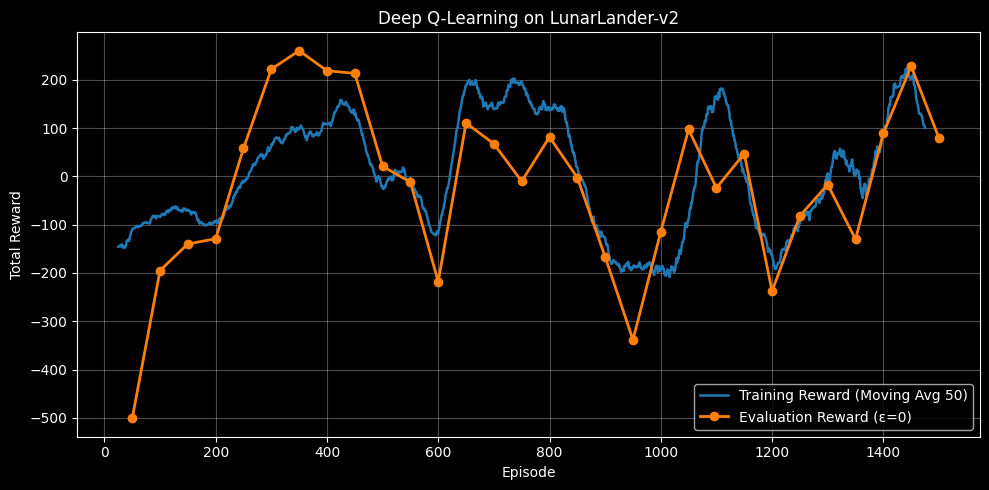

In [35]:

window = 50
if len(rewards_dqn) > window:
    smooth_rewards = np.convolve(rewards_dqn, np.ones(window)/window, mode="valid")
    smooth_episodes = np.arange(window//2, window//2 + len(smooth_rewards))
else:
    smooth_rewards = rewards_dqn
    smooth_episodes = np.arange(len(rewards_dqn))

plt.figure(figsize=(10,5))
plt.plot(smooth_episodes, smooth_rewards, label=f"Training Reward (Moving Avg {window})",
         color="tab:blue", linewidth=1.8)
plt.plot(eval_eps, eval_rewards, "o-", label="Evaluation Reward (ε=0)",
         color="tab:orange", linewidth=2, markersize=6)

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Deep Q-Learning on LunarLander-v2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The DQN agent started with very low rewards (around 500) but began improving after about 250 episodes. By around 300–400 episodes, it reached average rewards above 200, meaning it learned to land successfully most of the time. After that, performance sometimes fluctuated, which is common for DQN because training depends on replay samples and target updates.

The replay buffer and Adam optimizer helped make learning stable, but when ε became small, exploration dropped and performance varied more.

Compared to MountainCar, LunarLander is harder because it has more state variables, more actions, and complex physics. Tile coding worked for MountainCar, but LunarLander needs DQN to handle continuous states and more difficult control.